In [29]:
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt

# The following lines adjust the granularity of reporting.
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

In [30]:
train_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv")
test_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv")

In [31]:
scale_factor = 1000.0

# Scale the training set's label.
train_df["median_house_value"] /= scale_factor

# Scale the test set's label
test_df["median_house_value"] /= scale_factor

# Define a synthetic feature named rooms_per_person
train_df["rooms_per_person"] = train_df["total_rooms"] / train_df["population"]

In [33]:
train_df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_person
count,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0
mean,-119.6,35.6,28.6,2643.7,539.4,1429.6,501.2,3.9,207.3,2.0
std,2.0,2.1,12.6,2179.9,421.5,1147.9,384.5,1.9,116.0,1.2
min,-124.3,32.5,1.0,2.0,1.0,3.0,1.0,0.5,15.0,0.0
25%,-121.8,33.9,18.0,1462.0,297.0,790.0,282.0,2.6,119.4,1.5
50%,-118.5,34.2,29.0,2127.0,434.0,1167.0,409.0,3.5,180.4,1.9
75%,-118.0,37.7,37.0,3151.2,648.2,1721.0,605.2,4.8,265.0,2.3
max,-114.3,42.0,52.0,37937.0,6445.0,35682.0,6082.0,15.0,500.0,55.2


In [34]:
test_df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,3000.0,3000.0,3000.0,3000.0,3000.0,3000.0,3000.0,3000.0,3000.0
mean,-119.6,35.6,28.8,2599.6,530.0,1402.8,489.9,3.8,205.8
std,2.0,2.1,12.6,2155.6,415.7,1030.5,365.4,1.9,113.1
min,-124.2,32.6,1.0,6.0,2.0,5.0,2.0,0.5,22.5
25%,-121.8,33.9,18.0,1401.0,291.0,780.0,273.0,2.5,121.2
50%,-118.5,34.3,29.0,2106.0,437.0,1155.0,409.5,3.5,177.6
75%,-118.0,37.7,37.0,3129.0,636.0,1742.8,597.2,4.7,264.0
max,-114.5,41.9,52.0,30450.0,5419.0,11935.0,4930.0,15.0,500.0


In [38]:
shuffled_train_df = train_df.reindex(np.random.permutation(train_df.index))

# Print the first rows of the pandas DataFrame.
shuffled_train_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_person
5845,-118.2,34.0,52.0,583.0,157.0,730.0,174.0,1.4,140.6,0.8
5087,-118.1,33.9,27.0,580.0,143.0,466.0,133.0,3.1,187.5,1.2
7985,-118.4,34.0,44.0,2298.0,388.0,849.0,360.0,5.6,363.5,2.7
14912,-122.2,37.8,52.0,3494.0,396.0,1192.0,383.0,12.4,500.0,2.9
6967,-118.3,34.0,52.0,1793.0,350.0,1303.0,366.0,3.1,123.7,1.4


In [25]:
#@title Define the functions that build and train a model
def build_model(my_learning_rate):
  """Create and compile a simple linear regression model."""
  # Most simple tf.keras models are sequential.
  model = tf.keras.models.Sequential()

  # Add one linear layer to the model to yield a simple linear regressor.
  model.add(tf.keras.layers.Dense(units=1, input_shape=(1,)))

  # Compile the model topography into code that TensorFlow can efficiently
  # execute. Configure training to minimize the model's mean squared error.
  model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=my_learning_rate),
                loss="mean_squared_error",
                metrics=[tf.keras.metrics.RootMeanSquaredError()])

  return model


def train_model(model, df, feature, label, my_epochs,
                my_batch_size=None, my_validation_split=0.1):
  """Feed a dataset into the model in order to train it."""

  history = model.fit(x=df[feature],
                      y=df[label],
                      batch_size=my_batch_size,
                      epochs=my_epochs,
                      validation_split=my_validation_split)

  # The list of epochs is stored separately from the
  # rest of history.
  epochs = history.epoch

  # Isolate the root mean squared error for each epoch.
  hist = pd.DataFrame(history.history)
  rmse = hist["root_mean_squared_error"]

  return epochs, rmse, history.history

In [26]:
#@title Define the plotting function

def plot_the_loss_curve(epochs, mae_training, mae_validation):
  """Plot a curve of loss vs. epoch."""

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Root Mean Squared Error")

  plt.plot(epochs[1:], mae_training[1:], label="Training Loss")
  plt.plot(epochs[1:], mae_validation[1:], label="Validation Loss")
  plt.legend()

  # We're not going to plot the first epoch, since the loss on the first epoch
  # is often substantially greater than the loss for other epochs.
  merged_mae_lists = mae_training[1:] + mae_validation[1:]
  highest_loss = max(merged_mae_lists)
  lowest_loss = min(merged_mae_lists)
  delta = highest_loss - lowest_loss
  print(delta)

  top_of_y_axis = highest_loss + (delta * 0.05)
  bottom_of_y_axis = lowest_loss - (delta * 0.05)

  plt.ylim([bottom_of_y_axis, top_of_y_axis])
  plt.show()

In [ ]:
# Use the model to make predictions
def predict_house_values(model, df, n, feature, label):
  """Predict house values based on a feature."""

  batch = df[feature][10000:10000 + n]
  predicted_values = model.predict_on_batch(x=batch)

  print("feature   label          predicted")
  print("  value   value          value")
  print("          in thousand$   in thousand$")
  print("--------------------------------------")
  for i in range(n):
    print ("%5.0f %6.0f %15.0f" % (df[feature][i],
                                   df[label][i],
                                   predicted_values[i][0]))

In [39]:
# The following variables are the hyperparameters.
learning_rate = 0.08
epochs = 30
batch_size = 100

# Split the original training set into a reduced training set and a
# validation set.
validation_split=0.2

# Identify the feature and the label.
my_feature="median_income"  # the median income on a specific city block.
my_label="median_house_value" # the median value of a house on a specific city block.
# That is, you're going to create a model that predicts house value based
# solely on the neighborhood's median income.

# Discard any pre-existing version of the model.
my_model = None

# Invoke the functions.
my_model = build_model(learning_rate)
epochs, rmse, history = train_model(my_model, shuffled_train_df, my_feature,
                                    my_label, epochs, batch_size,
                                    validation_split)

Epoch 1/30
136/136 [==============================] - 0s 979us/step - loss: 43033.9922 - root_mean_squared_error: 207.4464 - val_loss: 33159.3164 - val_root_mean_squared_error: 182.0970
Epoch 2/30
136/136 [==============================] - 0s 718us/step - loss: 25120.8652 - root_mean_squared_error: 158.4956 - val_loss: 18223.5488 - val_root_mean_squared_error: 134.9946
Epoch 3/30
136/136 [==============================] - 0s 814us/step - loss: 13555.8613 - root_mean_squared_error: 116.4296 - val_loss: 9653.0693 - val_root_mean_squared_error: 98.2500
Epoch 4/30
136/136 

74.791748046875


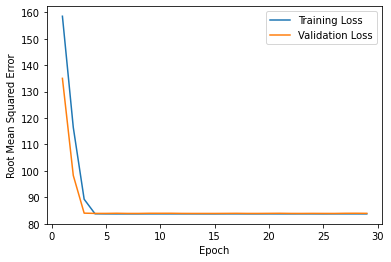

In [40]:
plot_the_loss_curve(epochs, history["root_mean_squared_error"],
                    history["val_root_mean_squared_error"])

In [43]:
# Use the Test Dataset to Evaluate Your Model's Performance

x_test = test_df[my_feature]
y_test = test_df[my_label]

results = my_model.evaluate(x_test, y_test, batch_size=batch_size)

print(results)


30/30 [==============================] - 0s 538us/step - loss: 7010.5771 - root_mean_squared_error: 83.7292
[7010.5771484375, 83.72918701171875]
